In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import interp1d
from tqdm import tqdm

from astropy import cosmology
from astropy.cosmology import z_at_value
import astropy.units as u  
cosmo = cosmology.Planck15

from IPython.core.debugger import set_trace

from bounded_Nd_kde import Bounded_Nd_kde
import peters

In [2]:
# parameters to be used when selecting samples

z_max = 10 #max redshift of the sample
mchirp_max = 80 #max chirp mass
Nsamp_max = None #samples we draw to build our population, will use all if None

params = ['mchirp','q','chieff','z']

base_path = '/Users/michaelzevin/research/model_selection/model_selection/data/spin_models/'

In [3]:
# useful functions

def mchirp(m1,m2):
    return (m1*m2)**(3./5) / (m1+m1)**(1./5)

def massratio(m1,m2):
    q = m2/m1
    pos_idxs = q.loc[q > 1.0].index
    q.loc[pos_idxs] = q.loc[pos_idxs]**-1
    return q

def gen_spinvecs_from_chitilt(chis, tilts):
    thetas = np.random.uniform(0, 2*np.pi, size=len(chis))
    sx = chis*np.cos(thetas)*np.sin(tilts)
    sy = chis*np.sin(thetas)*np.sin(tilts)
    sz = chis*np.cos(tilts)
    return sx, sy, sz

def gen_iso_spinvecs(chis):
    thetas = np.random.uniform(0, 2*np.pi, size=len(chis))
    phis = np.arccos(np.random.uniform(-1,1, size=len(chis)))
    sx = chis*np.cos(thetas)*np.sin(phis)
    sy = chis*np.sin(thetas)*np.sin(phis)
    sz = chis*np.cos(phis)
    return sx, sy, sz

def chieff(m1,m2,s1z,s2z):
    return (m1*s1z + m2*s2z) / (m1+m2)

def smear_zero_spin(N, sig=0.005):
    chi = norm.rvs(loc=0, scale=sig, size=N)
    return np.abs(chi)

def plot_params(df, axs, spin_name, params=params, weights=None):
    for ax, param in zip(axs,params):
        if weights is not None:
            ax.hist(df[param], bins=50, histtype='step', weights=weights)
        if spin_name == 'chi00':
            ax.set_xlabel(param)
            #ax.set_yscale('log')
    return

In [4]:
# Star formation and metallicity evolution

Zsun = 0.017 #Solar metallicity
lowZ = Zsun/200 #lower bound on metallicity
highZ = 2*Zsun #upper bound on metallicity
sigmaZ = 0.5 #sigma of the lognormal distribution about the mean metallicity

def sfr_z(z, mdl='2017'):
    """
    Star formation rate as a function in redshift, in units of M_sun / Mpc^3 / yr
    mdl='2017': Default, from Madau & Fragos 2017. Tassos added more X-ray binaries at higher Z, brings rates down
    mdl='2014': From Madau & Dickenson 2014, used in Belczynski et al. 2016
        """
    if mdl=='2017':
        return 0.01*(1+z)**(2.6)  / (1+((1+z)/3.2)**6.2)
    if mdl=='2014':
        return 0.015*(1+z)**(2.7) / (1+((1+z)/2.9)**5.6)

def mean_metal_z(z):
    """
    Mean (mass-weighted) metallicity as a function of redshift
    From Madau & Fragos 2017
    
    Returns [O/H] metallicity (not in Zsun units)
    """
    log_Z_Zsun = 0.153 - 0.074 * z**(1.34)
    return 10**(log_Z_Zsun) * Zsun

def metal_disp_z(z, Z, sigma_Z=sigmaZ, lowZ=lowZ, highZ=highZ):
    """
    Gives a weight for each metallicity Z at a redshift of z by assuming
    the metallicities are log-normally distributed about Z 
    
    Metallicities are in standard units ([Fe/H])
    Default dispersion is half a dex
    
    lowZ and highZ indicate the lower and upper metallicity bounds; values drawn below these
    will be reflected to ensure the distribution is properly normalized
    
    NOTE: Be careful in calculating the mean of a log-normal distribution correctly!
    """
    log_mean_Z = np.log10(mean_metal_z(z)) - (np.log(10)/2)*sigmaZ**2
    
    Z_dist = norm(loc=log_mean_Z, scale=sigmaZ)
    Z_dist_above = norm(loc=2*np.log10(highZ)-log_mean_Z, scale=sigmaZ)
    Z_dist_below = norm(loc=2*np.log10(lowZ)-log_mean_Z, scale=sigmaZ)
    
    density = Z_dist.pdf(np.log10(Z)) + Z_dist_above.pdf(np.log10(Z)) + Z_dist_below.pdf(np.log10(Z))
    
    return density

### Common Envelope

In [5]:
alpha_vals = ['0.20', '0.50', '1.0', '2.0', '5.0']
alpha_names = ['alpha02','alpha05','alpha10','alpha20','alpha50']

spin_vals = [0.0,0.1,0.2,0.5]
spin_names = ['chi00','chi01','chi02','chi05']

100%|██████████| 5/5 [07:14<00:00, 86.92s/it]


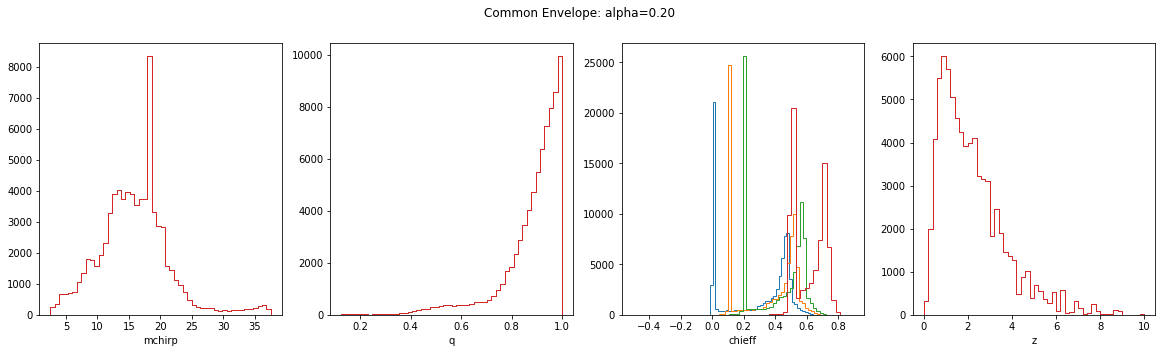

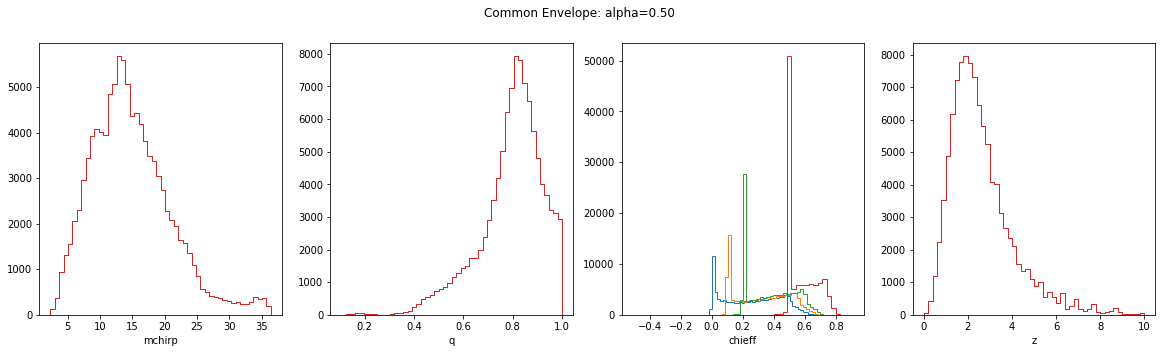

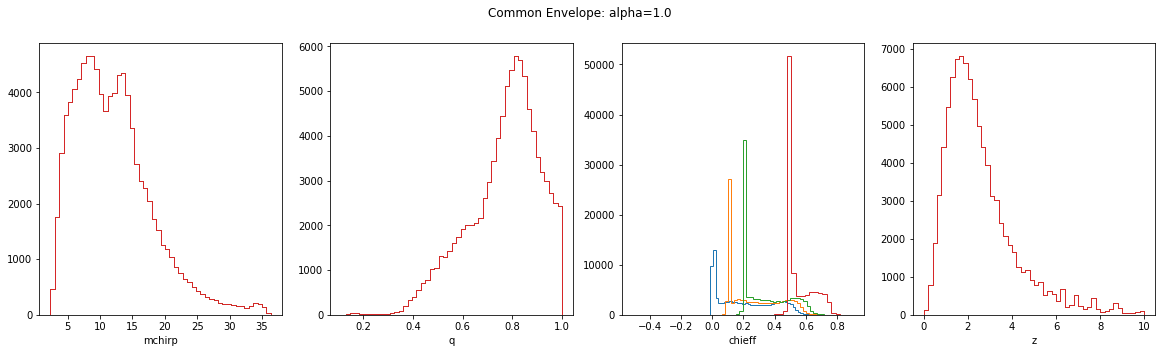

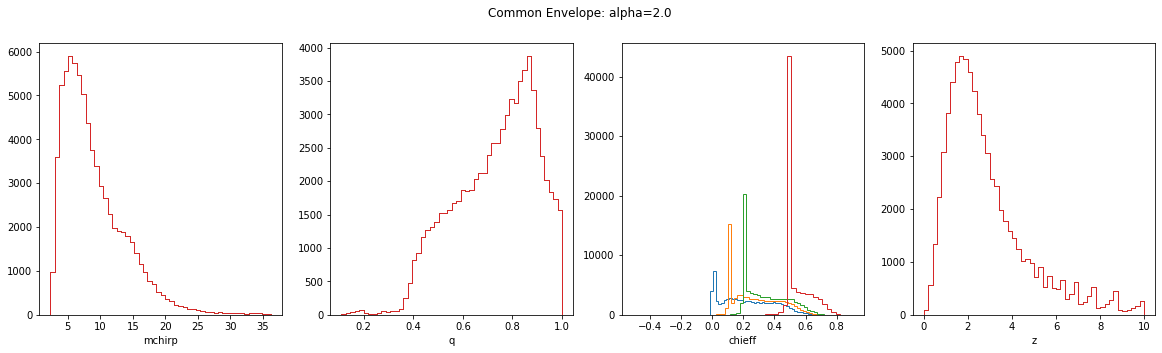

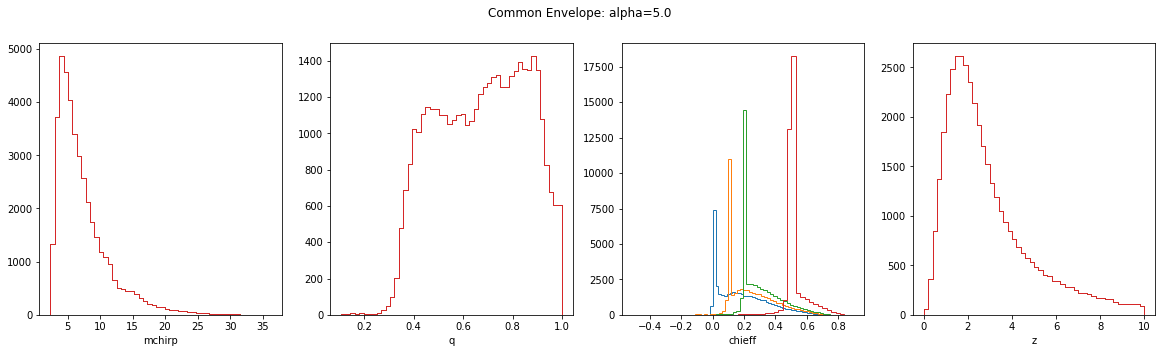

In [6]:
for alpha, alpha_name in tqdm(zip(alpha_vals, alpha_names), total=len(alpha_vals)):
    
    # read in CE systems first
    data = np.load(os.path.join(base_path,'CE/infinite_sensitivity_alpha_'+str(alpha)+'.npz'))

    index = data['index']
    a_2 = data['a_2'][index]
    tilt = data['tilt'][index]
    m_BH1 = data['m_BH1'][index]
    m_BH2 = data['m_BH2'][index]
    z_formation = data['z_formation']
    z_merger = data['z_merger']
    weights = data['weights']

    data = pd.DataFrame(np.transpose([m_BH1,m_BH2,a_2,tilt,z_merger,weights]), columns=['m1','m2','a2','tilt2','z','weight'])
    
    # remove the few systems that have NaNs for secondary spins (between the NS and BH boundary)
    data = data.loc[data.isnull().any(axis=1)==False]
    
    # use only merger redshifts less than z_max
    data = data.loc[data['z'] < z_max]

    # get necessary params
    fig, axs = plt.subplots(1,4, figsize=(20,5))

    for val, spin_name in zip(spin_vals, spin_names):
        if Nsamp_max is not None:
            df = data.sample(Nsamp_max)#, weights=data['weight'])
        else:
            df = data.copy()

        # assign natal spin mag val to primary
        df['a1'] = val
        
        # if secondary spin is less than assumed natal spin, set it to this value instead
        df.loc[df.a2 < val, "a2"] = val
        
        # assume aligned spins
        df['tilt1'] = np.asarray(df['tilt2'])

        #  give random noise to spin values, make sure spins are not greater than 1
        for a in ['a1','a2']:
            df[a] = df[a] + smear_zero_spin(len(df))
            df.loc[df[a]>1, a] = 1.0

        df['mchirp'] = mchirp(df['m1'], df['m2'])
        df['q'] = massratio(df['m1'], df['m2'])
        df['tilt1'] = np.asarray(df['tilt2'])

        df['s1x'],df['s1y'],df['s1z'] = gen_spinvecs_from_chitilt(df['a1'], df['tilt1'])
        df['s2x'],df['s2y'],df['s2z'] = gen_spinvecs_from_chitilt(df['a2'], df['tilt2'])

        df['chieff'] = chieff(df['m1'], df['m2'], df['s1z'], df['s2z'])

        # max chirp mass cut
        df = df.loc[df['mchirp'] < mchirp_max]

        # plot
        plot_params(df, axs, spin_name, weights=df['weight'])
        fig.suptitle('Common Envelope: alpha={:s}'.format(alpha))

        df = df[['mchirp','q','chieff','z','m1','m2','s1x','s1y','s1z','s2x','s2y','s2z','weight']]
        df = df.reset_index(drop=True)
        df.to_hdf(os.path.join(base_path,'unweighted_models.hdf5'), key='/CE/'+spin_name+'/'+alpha_name, mode='a')

### Stable Mass Transfer

100%|██████████| 4/4 [00:23<00:00,  5.78s/it]


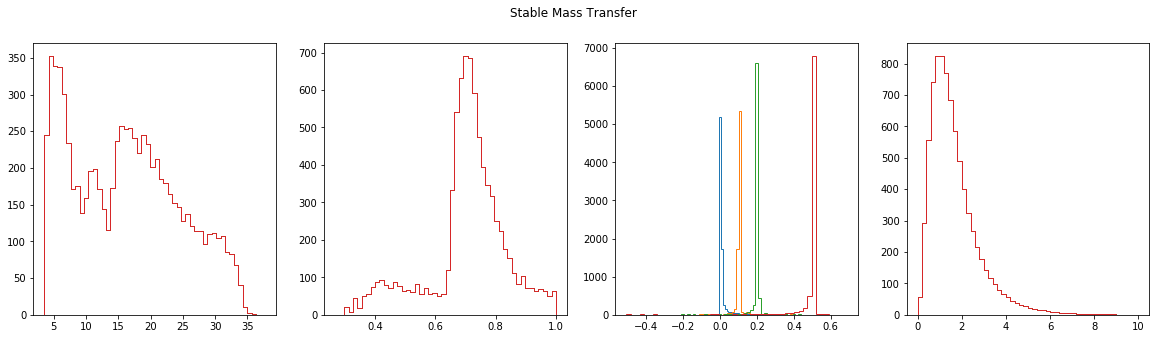

In [7]:
# read in SMT systems, all alphas are the same so just use one of them
data = np.load(os.path.join(base_path,'SMT/infinite_sensitivity_alpha_1.0.npz'))

index = data['index']
a_2 = data['a_2'][index]
tilt = data['tilt'][index]
m_BH1 = data['m_BH1'][index]
m_BH2 = data['m_BH2'][index]
z_formation = data['z_formation']
z_merger = data['z_merger']
weights = data['weights']

data = pd.DataFrame(np.transpose([m_BH1,m_BH2,a_2,tilt,z_merger,weights]), columns=['m1','m2','a2','tilt2','z','weight'])

# remove the few systems that have NaNs for secondary spins (between the NS and BH boundary)
data = data.loc[data.isnull().any(axis=1)==False]

# use only merger redshifts less than z_max
data = data.loc[data['z'] < z_max]

# get necessary params
fig, axs = plt.subplots(1,4, figsize=(20,5))

for val, name in tqdm(zip(spin_vals, spin_names), total=len(spin_vals)):
    if Nsamp_max is not None:
        df = data.sample(Nsamp_max)#, weights=data['weight'])
    else:
        df = data.copy()

    # assign natal spin mag val to primary
    df['a1'] = val

    # if secondary spin is less than assumed natal spin, set it to this value instead
    df.loc[df.a2 < val, "a2"] = val

    # assume aligned spins
    df['tilt1'] = np.asarray(df['tilt2'])

    #  give random noise to spin values, make sure spins are not greater than 1
    for a in ['a1','a2']:
        df[a] = df[a] + smear_zero_spin(len(df))
        df.loc[df[a]>1, a] = 1.0

    df['mchirp'] = mchirp(df['m1'], df['m2'])
    df['q'] = massratio(df['m1'], df['m2'])
    df['tilt1'] = np.asarray(df['tilt2'])

    df['s1x'],df['s1y'],df['s1z'] = gen_spinvecs_from_chitilt(df['a1'], df['tilt1'])
    df['s2x'],df['s2y'],df['s2z'] = gen_spinvecs_from_chitilt(df['a2'], df['tilt2'])

    df['chieff'] = chieff(df['m1'], df['m2'], df['s1z'], df['s2z'])

    # max chirp mass cut
    df = df.loc[df['mchirp'] < mchirp_max]

    # plot
    plot_params(df, axs, spin_name, weights=df['weight'])
    fig.suptitle('Stable Mass Transfer')

    df = df[['mchirp','q','chieff','z','m1','m2','s1x','s1y','s1z','s2x','s2y','s2z','weight']]
    df = df.reset_index(drop=True)
    df.to_hdf(os.path.join(base_path,'unweighted_models.hdf5'), key='/SMT/'+name, mode='a')

### Chemically Homogeneous Evolution

In [8]:
data = np.load(os.path.join(base_path,'CHE/infinite_sensitivity.npz'))

index = data['index']
a_1 = data['a_1'][index]
a_2 = data['a_2'][index]
m_BH1 = data['m_BH1'][index]
m_BH2 = data['m_BH2'][index]
Mtot = m_BH1+m_BH2
# artificially spread the mass ratios between [0.8,1.0]
q = np.random.uniform(0.8,1.0,len(m_BH1))
m_BH1 = Mtot / (1+q)
m_BH2 = q*Mtot / (1+q)
z_formation = data['z_formation']
z_merger = data['z_merger']
weights = data['weights']

data = pd.DataFrame(np.transpose([m_BH1,m_BH2,a_1,a_2,z_merger,weights]), columns=['m1','m2','a1','a2','z','weight'])

# use only merger redshifts less than z_max
data = data.loc[data['z'] < z_max]

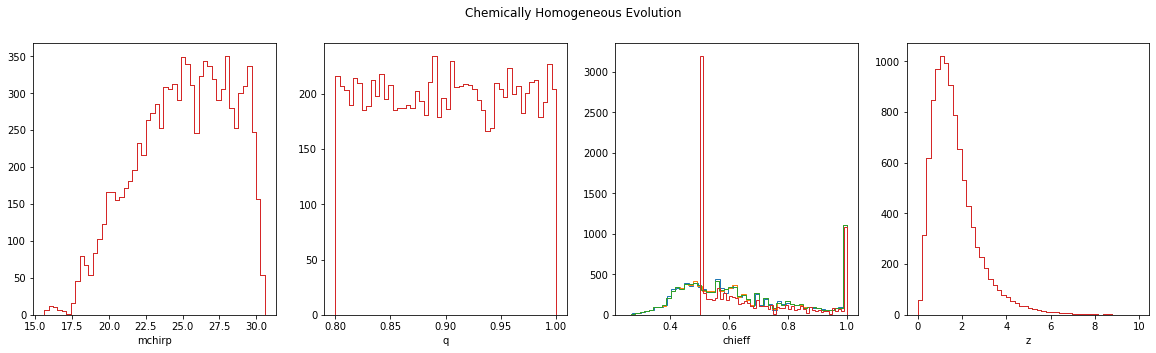

In [9]:
fig, axs = plt.subplots(1,4, figsize=(20,5))

for val, name in zip([0.0,0.1,0.2,0.5],['chi00','chi01','chi02','chi05']):
    if Nsamp_max is not None:
        df = data.sample(Nsamp_max)#, weights=data['weight'], replace=True)
    else:
        df = data.copy()

    # if spin is less than assumed natal spin, set it to this value instead
    df.loc[df.a1 < val, "a1"] = val
    df.loc[df.a2 < val, "a2"] = val
    
    # give random noise to spin values, make sure spins are not greater than 1
    for a in ['a1','a2']:
        df[a] = df[a] + smear_zero_spin(len(df))
        df.loc[df[a]>1, a] = 1.0
    
    df['mchirp'] = mchirp(df['m1'], df['m2'])
    df['q'] = massratio(df['m1'], df['m2'])
    df['tilt1'] = np.zeros(len(df))
    df['tilt2'] = np.zeros(len(df))  
    df['s1x'],df['s1y'],df['s1z'] = gen_spinvecs_from_chitilt(df['a1'], df['tilt1'])
    df['s2x'],df['s2y'],df['s2z'] = gen_spinvecs_from_chitilt(df['a2'], df['tilt2'])
    df['chieff'] = chieff(df['m1'], df['m2'], df['s1z'], df['s2z'])
    
    # max chirp mass cut
    df = df.loc[df['mchirp'] < mchirp_max]
        
    # plot
    plot_params(df, axs, name, weights=df['weight'])
    fig.suptitle('Chemically Homogeneous Evolution')
    
    df = df[['mchirp','q','chieff','z','m1','m2','s1x','s1y','s1z','s2x','s2y','s2z','weight']]
    df = df.reset_index(drop=True)
    df.to_hdf(os.path.join(base_path,'unweighted_models.hdf5'), key='/CHE/'+name, mode='a')

### Globular Clusters

In [10]:
data = pd.read_csv(os.path.join(base_path,'GC/one_sample.dat'), sep=' ')

data = data.rename(columns={'chi_1':'a1', 'chi_2':'a2'})

# give random noise to spin values, make sure spins are not greater than 1
for a in ['a1','a2']:
    data[a] = data[a] + smear_zero_spin(len(data))
    data.loc[data[a]>1, a] = 1.0

data['mchirp'] = mchirp(data['m1'], data['m2'])
data['q'] = massratio(data['m1'], data['m2'])
data['s1x'],data['s1y'],data['s1z'] = gen_iso_spinvecs(data['a1'])
data['s2x'],data['s2y'],data['s2z'] = gen_iso_spinvecs(data['a2'])
data['chieff'] = chieff(data['m1'], data['m2'], data['s1z'], data['s2z'])

In [11]:
data = pd.read_csv(os.path.join(base_path,'GC/one_sample.dat'), sep=' ')

data = data.rename(columns={'chi_1':'a1', 'chi_2':'a2'})

# give random noise to spin values, make sure spins are not greater than 1
for a in ['a1','a2']:
    data[a] = data[a] + smear_zero_spin(len(data))
    data.loc[data[a]>1, a] = 1.0

data['mchirp'] = mchirp(data['m1'], data['m2'])
data['q'] = massratio(data['m1'], data['m2'])
data['s1x'],data['s1y'],data['s1z'] = gen_iso_spinvecs(data['a1'])
data['s2x'],data['s2y'],data['s2z'] = gen_iso_spinvecs(data['a2'])
data['chieff'] = chieff(data['m1'], data['m2'], data['s1z'], data['s2z'])

# only use systems with z<z_max
data = data.loc[data['z'] < z_max]

# since the redshifts didn't account for a volume factor, recalculate the weights
z = data['z']
Vc_weight = cosmo.differential_comoving_volume(z) * (1+z)**(-1)
Vc_weight = Vc_weight / np.sum(Vc_weight)

data['weight'] = data['weight']*Vc_weight

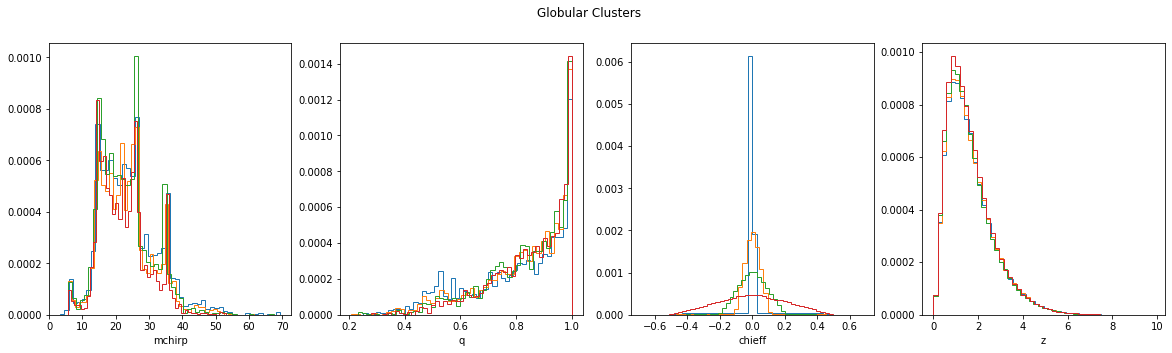

In [12]:
fig, axs = plt.subplots(1,4, figsize=(20,5))
    
for chib, name in zip([0.0, 0.1, 0.2, 0.5],['chi00','chi01','chi02','chi05']):
    df = data.loc[data['chi_b'] == chib]
    if Nsamp_max is not None:
        df = df.sample(Nsamp_max)#, weights=data['weight'], replace=True)
    else:
        df = df.copy()
        
    df = df[['mchirp','q','chieff','z','m1','m2','s1x','s1y','s1z','s2x','s2y','s2z','weight']]
    
    # max chirp mass cut
    df = df.loc[df['mchirp'] < mchirp_max]
    
    # plot
    plot_params(df, axs, name, weights=df['weight'])
    fig.suptitle('Globular Clusters')
    
    # save data
    df = df.reset_index(drop=True)
    df.to_hdf(os.path.join(base_path,'unweighted_models.hdf5'), key='/GC/'+name, mode='a')

###  Nuclear Star Clusters

In [13]:
def read_NSC_data(path):
    columns = ['Mtot','m1','m2','t_delay','z_model','M_clus','rho0','af','a1','a2','location']
    data = pd.read_csv(path, delim_whitespace=True, header=None, names=columns)
    
    # give random noise to spin values, make sure spins are not greater than 1
    for a in ['a1','a2']:
        data[a] = data[a] + smear_zero_spin(len(data))
        data.loc[data[a]>1, a] = 1.0

    # change t_delay to Gyr
    data['t_delay'] *= u.yr.to(u.Gyr)
    return data

In [14]:
# create t_lookback to redshift interpolant

tl_max = cosmo.lookback_time(z_max)
lookback_times = np.logspace(-5, np.log10(tl_max.value), 1000)
redz = np.asarray([z_at_value(cosmo.lookback_time, tlb*u.Gyr) for tlb in lookback_times])
z_from_tlb = interp1d(lookback_times, redz)

Processing data for chi00 NSC run...
  calculaing redshift distribution of mergers for 0.0002
    converting to merger redshifts...


  0%|          | 9/57368 [00:00<10:38, 89.78it/s]

    calculating metallicity weights...


100%|██████████| 57368/57368 [02:52<00:00, 332.17it/s]


  calculaing redshift distribution of mergers for 0.002
    converting to merger redshifts...


  0%|          | 20/49619 [00:00<04:09, 198.85it/s]

    calculating metallicity weights...


100%|██████████| 49619/49619 [02:14<00:00, 369.92it/s]


  calculaing redshift distribution of mergers for 0.02
    converting to merger redshifts...


  0%|          | 7/69102 [00:00<16:49, 68.46it/s]

    calculating metallicity weights...


100%|██████████| 69102/69102 [03:13<00:00, 357.08it/s]


Processing data for chi01 NSC run...
  calculaing redshift distribution of mergers for 0.0002
    converting to merger redshifts...


  0%|          | 19/55314 [00:00<04:55, 187.10it/s]

    calculating metallicity weights...


100%|██████████| 55314/55314 [02:42<00:00, 340.77it/s]


  calculaing redshift distribution of mergers for 0.002
    converting to merger redshifts...


  0%|          | 45/53173 [00:00<05:45, 153.64it/s]

    calculating metallicity weights...


100%|██████████| 53173/53173 [02:23<00:00, 371.43it/s]


  calculaing redshift distribution of mergers for 0.02
    converting to merger redshifts...


  0%|          | 4/78028 [00:00<32:31, 39.99it/s]

    calculating metallicity weights...


100%|██████████| 78028/78028 [03:28<00:00, 374.49it/s]


Processing data for chi02 NSC run...
  calculaing redshift distribution of mergers for 0.0002
    converting to merger redshifts...


  0%|          | 13/59682 [00:00<07:43, 128.70it/s]

    calculating metallicity weights...


100%|██████████| 59682/59682 [02:29<00:00, 399.93it/s]


  calculaing redshift distribution of mergers for 0.002
    converting to merger redshifts...


  0%|          | 19/58729 [00:00<05:15, 186.19it/s]

    calculating metallicity weights...


100%|██████████| 58729/58729 [02:33<00:00, 382.49it/s]


  calculaing redshift distribution of mergers for 0.02
    converting to merger redshifts...


  0%|          | 5/79029 [00:00<26:42, 49.33it/s]

    calculating metallicity weights...


100%|██████████| 79029/79029 [03:35<00:00, 365.98it/s]


Processing data for chi05 NSC run...
  calculaing redshift distribution of mergers for 0.0002
    converting to merger redshifts...


  0%|          | 15/63337 [00:00<07:10, 147.12it/s]

    calculating metallicity weights...


100%|██████████| 63337/63337 [02:40<00:00, 394.74it/s]


  calculaing redshift distribution of mergers for 0.002
    converting to merger redshifts...


  0%|          | 60/33279 [00:00<02:35, 213.73it/s]

    calculating metallicity weights...


100%|██████████| 33279/33279 [01:23<00:00, 399.87it/s]


  calculaing redshift distribution of mergers for 0.02
    converting to merger redshifts...


  0%|          | 1/96565 [00:00<3:35:17,  7.48it/s]

    calculating metallicity weights...


100%|██████████| 96565/96565 [04:11<00:00, 384.38it/s]


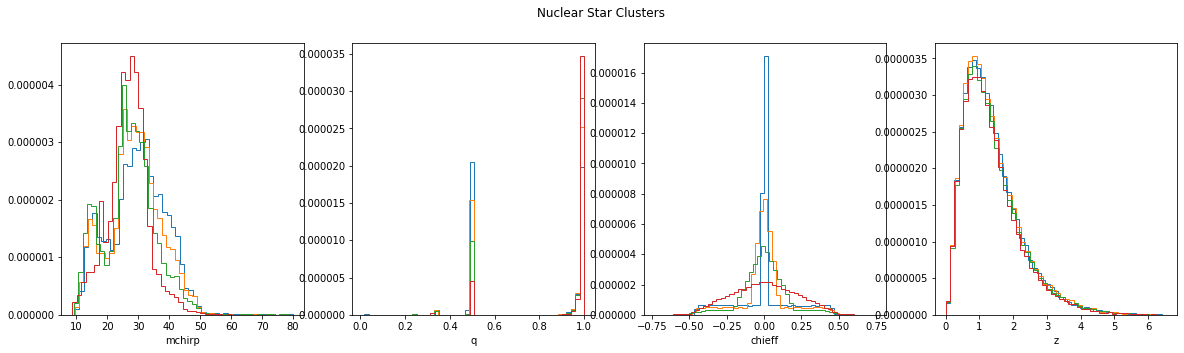

In [20]:
method = 'sfr'
#method = 'delta_burst'

fig, axs = plt.subplots(1,4, figsize=(20,5))

for name, subdir in zip(['chi00','chi01','chi02','chi05'], ['0Spin','01Spin','02Spin','05Spin']):
    print("Processing data for {} NSC run...".format(name))
    met_dict = {}
    met_dict['0.0002'] = read_NSC_data(os.path.join(base_path,'NSC/'+subdir+'/1%/out.dat'))
    met_dict['0.002'] = read_NSC_data(os.path.join(base_path,'NSC/'+subdir+'/10%/out.dat'))
    met_dict['0.02'] = read_NSC_data(os.path.join(base_path,'NSC/'+subdir+'/100%/out.dat'))

    df = pd.DataFrame()

    if method == 'delta_burst':
        # Assume all systems are born 10 Gyr ago
        for met, model in met_dict.items():
            print("  calculaing redshift distribution of mergers for {}".format(met))
            # get merger times
            met_dict[met] = met_dict[met].assign(t_birth = 10)
            met_dict[met] = met_dict[met].assign(t_merge = met_dict[met]['t_birth'] - met_dict[met]['t_delay'])
            
            # only take systems that merge within a Hubble time and at redshfits less than z_max
            tlb_zmax = cosmo.lookback_time(z_max).to(u.Gyr).value
            met_dict[met] = met_dict[met].loc[(met_dict[met]['t_merge'] >= 0) & (met_dict[met]['t_merge'] <= tlb_zmax)]
            
            # get merger redshifts
            print("    converting to merger redshifts...")
            z_merge = z_from_tlb(met_dict[met]['t_merge'])
            met_dict[met] = met_dict[met].assign(z_merge = np.asarray(z_merge))

            # since the redshifts didn't account for a volume factor, calculate volume weights
            z = met_dict[met]['z_merge']
            Vc_weight = cosmo.differential_comoving_volume(z) * (1+z)**(-1)
            Vc_weight = Vc_weight / np.sum(Vc_weight)
            met_dict[met] = met_dict[met].assign(weight = Vc_weight)
            
        # get same number of samples for each met
        Nmin_all_mets  = np.min([len(met_dict['0.0002']),len(met_dict['0.002']),len(met_dict['0.02'])])
        for df_tmp in [met_dict['0.0002'],met_dict['0.002'],met_dict['0.02']]:
            df = df.append(df_tmp.sample(Nmin_all_mets, replace=False))
        
        """rand_numbers = 3*np.random.random(size=n_samp)
        N100 = len(np.where((rand_numbers >= 0) & (rand_numbers <= 1))[0])
        N10 = len(np.where((rand_numbers > 1) & (rand_numbers <= 2))[0])
        N1 = len(np.where((rand_numbers > 2) & (rand_numbers <= 3))[0])

        for df_tmp, N in zip([met_dict['0.0002'],met_dict['0.002'],met_dict['0.02']],[N100,N10,N1]):
            if len(df_tmp) < N:
                df = df.append(df_tmp.sample(N, weights=df_tmp['cosmo_weight'], replace=True))
            else:
                df = df.append(df_tmp.sample(N, weights=df_tmp['cosmo_weight'], replace=False))"""
    
    if method == 'sfr':
        for met in met_dict.keys():
            print("  calculaing redshift distribution of mergers for {}".format(met))
            # get birth redshifts and birth times for each model, up to lookback time of 13 Gyr
            z_at_13Gyr = z_at_value(cosmo.lookback_time, 13*u.Gyr)
            z_grid = np.linspace(0, z_at_13Gyr, 100000)
            p_sfr = sfr_z(z_grid)
            p_sfr /= np.sum(p_sfr)
            met_dict[met] = met_dict[met].assign(z_birth = np.random.choice(z_grid, p=p_sfr, size=len(met_dict[met])))
            met_dict[met] = met_dict[met].assign(t_birth = cosmo.lookback_time(met_dict[met]['z_birth']).to(u.Gyr).value)
            
            # get merger times
            met_dict[met] = met_dict[met].assign(t_merge = (met_dict[met]['t_birth'] - met_dict[met]['t_delay']))

            # only take systems that merge within a Hubble time and at redshfits less than z_max
            tlb_zmax = cosmo.lookback_time(z_max).to(u.Gyr).value
            met_dict[met] = met_dict[met].loc[(met_dict[met]['t_merge'] >= 0) & (met_dict[met]['t_merge'] <= tlb_zmax)]
            
            # get merger redshifts
            print("    converting to merger redshifts...")
            z_merge = z_from_tlb(met_dict[met]['t_merge'])
            met_dict[met] = met_dict[met].assign(z_merge = np.asarray(z_merge))

            # since the redshifts didn't account for a volume factor, calculate volume weights
            z = met_dict[met]['z_merge']
            Vc_weight = cosmo.differential_comoving_volume(z) * (1+z)**(-1)
            Vc_weight = Vc_weight / np.sum(Vc_weight)
            met_dict[met] = met_dict[met].assign(cosmo_weight = Vc_weight)
            
            # get weight for this metallicity model at each formation redshift
            print("    calculating metallicity weights...")
            met_weights = []
            for idx, row in tqdm(met_dict[met].iterrows(), total=len(met_dict[met])):
                met_weights.append(metal_disp_z(row['z_birth'], float(met)))
            met_dict[met] = met_dict[met].assign(met_weight = (np.asarray(met_weights) / np.sum(met_weights)))
            
            # combine weights
            met_dict[met] = met_dict[met].assign(weight = met_dict[met]['cosmo_weight'] * met_dict[met]['met_weight'])
            
        # find metallicity run with the smallest number of samples
        Nmin_all_mets  = np.min([len(met_dict['0.0002']),len(met_dict['0.002']),len(met_dict['0.02'])])
        
        # combine all dataframes with an equal number of sources
        df = pd.DataFrame()
        for met in met_dict.keys():
            df_tmp = met_dict[met].sample(Nmin_all_mets, replace=False)
            df = df.append(df_tmp)


    # get pertinent data
    df['mchirp'] = mchirp(df['m1'], df['m2'])
    df['q'] = massratio(df['m1'], df['m2'])
    df['s1x'],df['s1y'],df['s1z'] = gen_iso_spinvecs(df['a1'])
    df['s2x'],df['s2y'],df['s2z'] = gen_iso_spinvecs(df['a2'])
    df['chieff'] = chieff(df['m1'], df['m2'], df['s1z'], df['s2z'])
    df = df.rename(columns={'z_merge': 'z'})
    df = df[['mchirp','q','chieff','z','m1','m2','s1x','s1y','s1z','s2x','s2y','s2z','weight']]
    
    # max chirp mass cut
    df = df.loc[df['mchirp'] < mchirp_max]

    # plot
    plot_params(df, axs, name, weights=df['weight'])
    fig.suptitle('Nuclear Star Clusters')

    # save data
    df = df.reset_index(drop=True)
    df.to_hdf(os.path.join(base_path,'unweighted_models.hdf5'), key='/NSC/'+name, mode='a')

### Triples

In [ ]:
columns = ['a1_final', 'e1_final', 'e2_final', 'time', 'theta1', 'theta2', 'dPhi', 'm1', 'm2', 'm3', 'a1_ini', 'e1_ini', 'n_cmenv', 'peri', 'num', 'meta']
data = pd.read_csv(os.path.join(base_path,'TRIP/triples_data.dat', sep=',', names=columns, skiprows=1))

# change time to Gyr
data['time'] = data['time']*u.yr.to(u.Gyr)
data = data.rename(columns={'time':'t_delay'})

# remove triples that merge within a Hubble time anyway
t_insp = []
for idx, row in tqdm(data.iterrows(), total=len(data)):
    t_insp.append(peters.inspiral_time_peters(row['a1_ini'], row['e1_ini'], row['m1'], row['m2']))
data['t_insp'] = np.asarray(t_insp)

data = data.loc[data['t_insp'] < 13.8]

# synthesize more data
data_tmp = data.copy()
for i in np.arange(7):
    data = data.append(data_tmp)


In [ ]:
# FIXME: probably need to generate more triple systems at different redshifts...

Processing data for chi00 TRIP run...
    converting to merger redshifts...


  0%|          | 41/48116 [00:00<01:58, 407.18it/s]

    calculating metallicity weights...


100%|██████████| 48116/48116 [01:44<00:00, 461.85it/s]


Processing data for chi01 TRIP run...
    converting to merger redshifts...


  0%|          | 40/48076 [00:00<02:02, 393.33it/s]

    calculating metallicity weights...


100%|██████████| 48076/48076 [01:45<00:00, 454.45it/s]


Processing data for chi02 TRIP run...
    converting to merger redshifts...


  0%|          | 41/47914 [00:00<01:58, 403.67it/s]

    calculating metallicity weights...


100%|██████████| 47914/47914 [01:45<00:00, 453.70it/s]


Processing data for chi05 TRIP run...
    converting to merger redshifts...


  0%|          | 41/48116 [00:00<01:59, 403.19it/s]

    calculating metallicity weights...


100%|██████████| 48116/48116 [01:45<00:00, 457.95it/s]


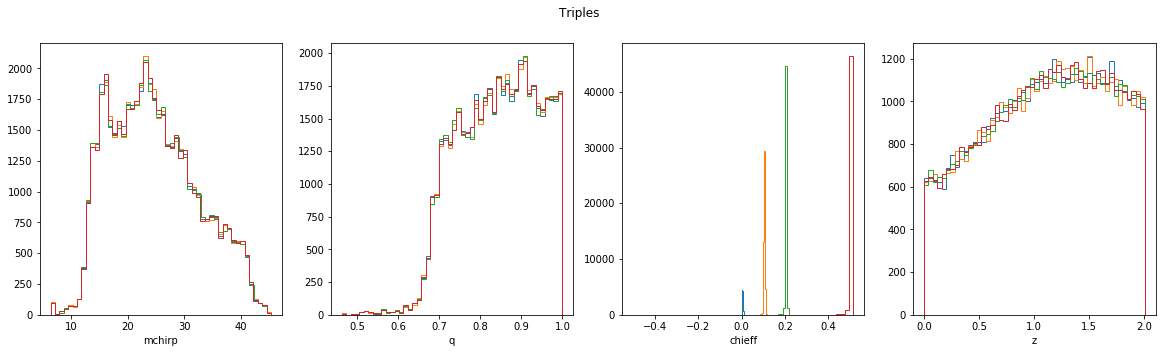

In [11]:
fig, axs = plt.subplots(1,4, figsize=(20,5))

for chib, name in zip([0.0, 0.1, 0.2, 0.5],['chi00','chi01','chi02','chi05']):
    print("Processing data for {} TRIP run...".format(name))
    df  = data.copy()
    df['a1'] = chib
    df['a2'] = chib
    
    # give random noise to spin values, make sure spins are not greater than 1
    for a in ['a1','a2']:
        df[a] = df[a] + smear_zero_spin(len(df))
        df.loc[df[a]>1, a] = 1.0
        
    # change theta tilts to radians
    df['theta1'] *= np.pi/180
    df['theta2'] *= np.pi/180
    
    # get pertinent data
    df['mchirp'] = mchirp(df['m1'], df['m2'])
    df['q'] = massratio(df['m1'], df['m2'])
    df['s1x'],df['s1y'],df['s1z'] = gen_spinvecs_from_chitilt(df['a1'], df['theta1'])
    df['s2x'],df['s2y'],df['s2z'] = gen_spinvecs_from_chitilt(df['a2'], df['theta2'])
    df['chieff'] = chieff(df['m1'], df['m2'], df['s1z'], df['s2z'])
    
    
    # get birth and merger redshifts, and weight according to metallicity
    z_at_13Gyr = z_at_value(cosmo.lookback_time, 13*u.Gyr)
    z_grid = np.linspace(0, z_at_13Gyr, 100000)
    p_sfr = sfr_z(z_grid)
    p_sfr /= np.sum(p_sfr)
    df['z_birth'] = np.random.choice(z_grid, p=p_sfr, size=len(df))
    df['t_birth'] = cosmo.lookback_time(df['z_birth']).to(u.Gyr).value

    # get merger times
    df['t_merge'] = df['t_birth'] - df['t_delay']

    # only take systems that merge within a Hubble time and at redshfits less than z_max
    tlb_zmax = cosmo.lookback_time(z_max).to(u.Gyr).value
    df = df.loc[(df['t_merge'] >= 0) & (df['t_merge'] <= tlb_zmax)]
    
    # get merger redshifts
    print("    converting to merger redshifts...")
    z_merge = z_from_tlb(df['t_merge'])
    df['z_merge'] = np.asarray(z_merge)

    # since the redshifts didn't account for a volume factor, calculate volume weights
    z = df['z_merge']
    Dc = cosmo.comoving_distance(z)
    Vc = 4./3*np.pi*Dc**3
    Vc_weight = Vc / np.sum(Vc)
    df['cosmo_weight'] = Vc_weight
            
    # get weight for this metallicity model at each formation redshift
    print("    calculating metallicity weights...")
    met_weights = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        met_weights.append(metal_disp_z(row['z_birth'], row['meta']))
    df['met_weight'] = (np.asarray(met_weights) / np.sum(met_weights))
    
    # save combined weight
    df['weight'] = df['cosmo_weight'] * df['met_weight']
    
    # select systems based on metallicity and cosmological volume weights
    if Nsamp_max is not None:
        if len(df) < n_samp:
            df = df.sample(n_samp, replace=True, weights=(df['cosmo_weight']*df['met_weight']))
        else:
            df = df.sample(n_samp, replace=False, weights=(df['cosmo_weight']*df['met_weight']))


    # save only parameters that we need
    df = df.rename(columns={'z_merge': 'z'})
    df = df[['mchirp','q','chieff','z','m1','m2','s1x','s1y','s1z','s2x','s2y','s2z','weight']]
    
    # max chirp mass cut
    df = df.loc[df['mchirp'] < mchirp_max]
        
    # plot
    plot_params(df, axs, name)
    fig.suptitle('Triples')
    
    # save data
    df = df.reset_index(drop=True)
    df.to_hdf(os.path.join(base_path,'unweighted_models.hdf5'), key='/TRIP/'+name, mode='a')